In [23]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la
from scipy.integrate import odeint

Running Python: 3.9.9


In [24]:
# define normalized 2D gaussian
def gaus2d(X, xbar, P):
    x,y = X
    s1 = np.sqrt(P[0,0])
    s2 = np.sqrt(P[1,1])
    rho12 = P[0,1]/s1/s2
    J = ((x - xbar[0])**2. / (s1**2.) -2*rho12/s1/s2*(x - xbar[0])*(y - xbar[1]) + (y - xbar[1])**2/(s2**2.))
    return 1/(2*np.pi*s1*s2*np.sqrt(1-rho12**2)) * np.exp(-J/2/(1-rho12**2))

# algorithm for finding discrete noise (see 7-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt=1):
    Nx = A.shape[0]
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = np.multiply(Bw,Wc)@Bw.T

    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]
    
    Nu = int(Bu.size/Nx)
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Wd, Ad, Bd 

In [25]:
# Cts second order system that is discretized using dt 
dt = 0.25 # 0.25 seconds between readings
Tf = 15 # final time
N = int(Tf/dt) # number of steps in sim

x0 = np.array([8, 3]) # initial condition
Q0 = np.array([[4, 0],[0, 0.5**2]]) # initial state uncertainty

A = np.array([[0, 1],[-1, -0.4]]) # cts A matrix
Nx = A.shape[0]
Bw = np.array([[0],[1]]) # cts noise input matrix
Wc = np.array([0.75**2]) # cts process noise
Wd, Ad, Bd = DiscretizeW(A,Bw,Wc,Bw,dt) # convert to discrete
sWd = sqrtm(Wd)

# Sense position state
Cd = np.array([[1, 0]]) # cts noise meas matrix
Rd = np.array([0.25**2]) # disc meas noise

# Motivational Example

In [26]:
# Discrete Prop (see Lecture 7) and sim
Nmeas = 10 # number of discrete time steps between measurements
Qdm = np.zeros((Nx,Nx,N+1))
Qdm[:,:,0] = Q0
Xdm = np.zeros((Nx,1,N+1))
Xdm[:,:,0] = np.vstack(x0)
Xsm = np.zeros((Nx,1,N+1))
Xsm[:,:,0] = np.vstack(x0)+sqrtm(Q0)@np.vstack(randn(2)) # random initial pt
for k in np.arange(1,N+1,1):
    Qdm[:,:,k] = Ad@Qdm[:,:,k-1]@Ad.T+Wd
    Xdm[:,:,k] = Ad@Xdm[:,:,k-1]
    Xsm[:,:,k] = Ad@Xsm[:,:,k-1] + sWd@np.vstack(randn(2))
    if (np.mod(k,Nmeas) == 0): # occasional measurements
        yk = Cd@Xsm[:,:,k] + sqrt(Rd)*randn(1) # meas with noise
        Lk = Qdm[:,:,k]@Cd.T/(Cd@Qdm[:,:,k]@Cd.T+Rd) # uses Q[k|k-1]
        Qdm[:,:,k] = (np.eye(2) - Lk@Cd)@Qdm[:,:,k] # creates Q[k|k]
        Xdm[:,:,k] += Lk*(yk - Cd@Xdm[:,:,k]) # uses x[k|k-1] to create x[k|k] 

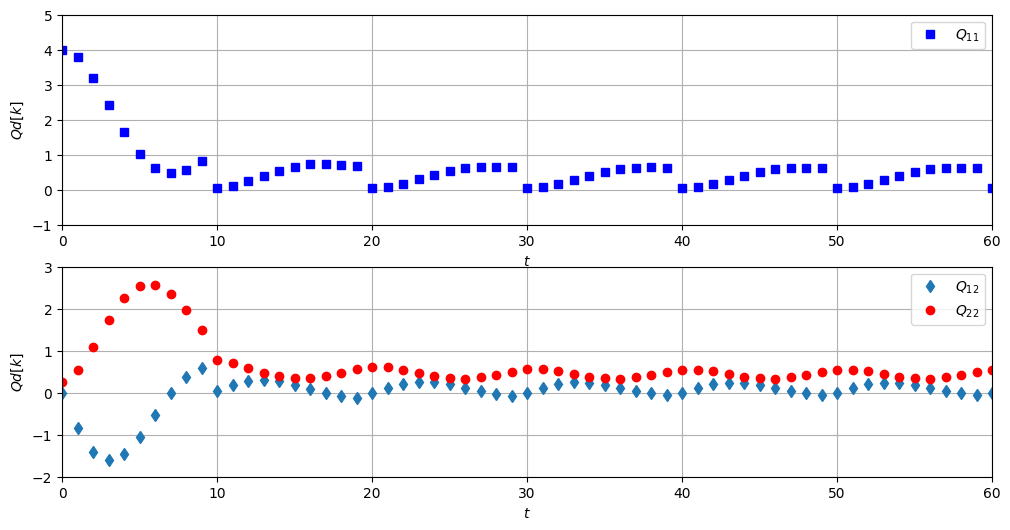

In [27]:
K=np.arange(0,N+1,1)
plt.figure(3,figsize=(12,6))
ax1 = plt.subplot(211)
ax1.plot(K,Qdm[0,0,:],'bs',label=r'$Q_{11}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$t$')
plt.xlim([0,N])
plt.ylim([-1,5])
plt.grid(True)
plt.legend(loc='best')
ax2 = plt.subplot(212)
ax2.plot(K,Qdm[0,1,:],'d',label=r'$Q_{12}$')
ax2.plot(K,Qdm[1,1,:],'ro',label=r'$Q_{22}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$t$')
plt.grid(True)
plt.legend(loc='best')
plt.xlim([0,N])
plt.ylim([-2,3])
plt.tight_layout
plt.show()

Plot above shows the response of the discrete covariance propagated using the discrete dynamics Ad, Wd and a measurement every Nmeas steps (10 here)

In [28]:
x = np.arange(-1*x0[0], 1.5*x0[0], 0.1)
y = np.arange(-1.5*x0[0], 1*x0[0], 0.1)
X, Y = np.meshgrid(x, y)

ZZ = 0.2 # color spacing
CP = np.arange(ZZ/10, ZZ, ZZ/5)
Nskip = int(Nmeas/3) # steps to skip in the visualization
def f(Nlim=0):
    fig = plt.figure(6,figsize=(10, 10)) 
    plt.xlabel(r"$p$")
    plt.ylabel(r"$v$")
    for k in np.arange(np.max([0,Nlim-2*Nskip]),Nlim+1,1):
        plt.plot(Xdm[0,0,k],Xdm[1,0,k], 'ro',label=r'$\bar x$')
        plt.plot(Xsm[0,0,k],Xsm[1,0,k], 'b.',label=r'$x$')
        if (k % Nskip == 0):
            Z = gaus2d([X, Y], Xdm[:,:,k], Qdm[:,:,k])
            cp = plt.contour(X, Y, Z, CP)
    plt.title('Prop with measurements. Nmeas = '+str(Nmeas)+' (number of steps between meas)')
    plt.show()

interactive_plot = interactive(f, {'manual': False}, Nlim=(0, N, 1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='Nlim', max=60), Output()), _dom_classes=('widget-interac…

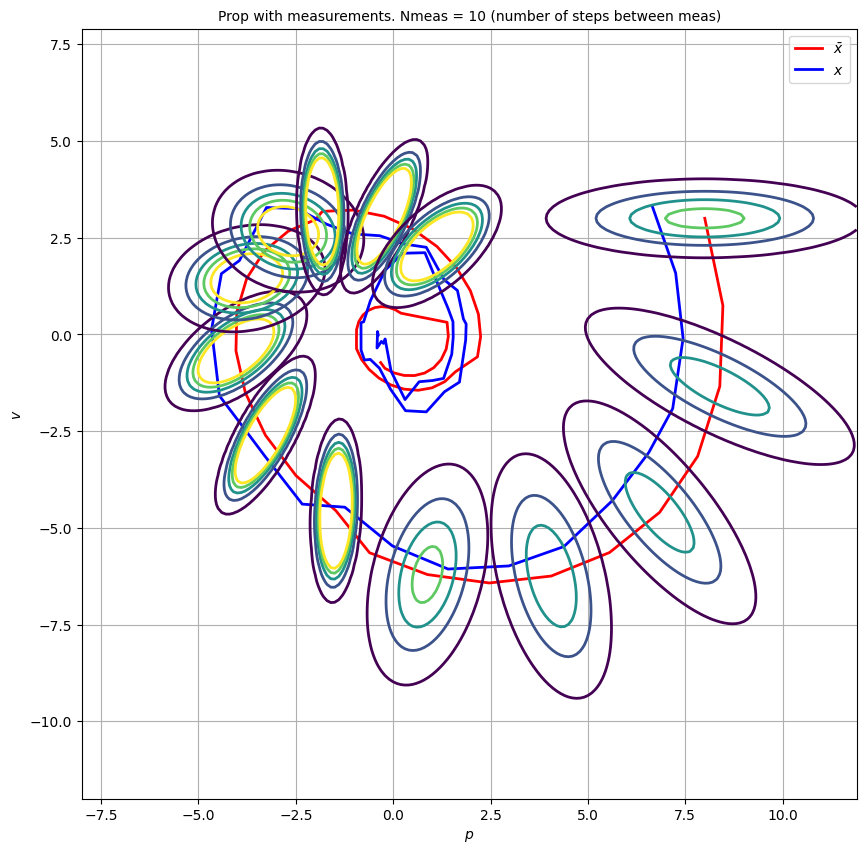

In [29]:
fig = plt.figure(7,figsize=(10, 10)) 
plt.xlabel(r"$p$")
plt.ylabel(r"$v$")
plt.plot(Xdm[0,0,:],Xdm[1,0,:], 'r-',label=r'$\bar x$')
plt.plot(Xsm[0,0,:],Xsm[1,0,:], 'b-',label=r'$x$')
for II in [ii for ii in range(25) if ii%2 == 0]:
    Z = gaus2d([X, Y], Xdm[:,:,II], Qdm[:,:,II])
    cp = plt.contour(X, Y, Z, CP)
plt.title('Prop with measurements. Nmeas = '+str(Nmeas)+' (number of steps between meas)')
plt.legend()
plt.show()